<a href="https://colab.research.google.com/github/hamednasr/transformers/blob/main/fine_tuning_machine_translation_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
!pip -q install transformers datasets sentencepiece sacrebleu bert-score

In [59]:
from datasets import load_dataset, load_metric
from transformers import (AutoTokenizer,
                          TrainingArguments,
                          Trainer,
                          AutoModelForSeq2SeqLM,
                          DataCollatorForSeq2Seq,
                          pipeline,
                          AutoConfig)
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = load_dataset('kde4',lang1 = 'en', lang2 ='fr')
data

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [4]:
data['train']['translation'][11]

{'en': 'The Babel & konqueror; plugin',
 'fr': 'Le module externe Babel pour & konqueror;'}

In [5]:
subdata = data['train'].shuffle(seed=2).select(range(1000))

In [6]:
split = subdata.train_test_split(test_size=0.1, seed=4)

In [7]:
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 900
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 100
    })
})

In [8]:
split['train']['translation'][22]

{'en': 'Ghostscript Resolution', 'fr': 'Résolution de Ghostscript'}

In [21]:
split['train']['translation'][3]['en']

'Could not decrypt the data.'

In [22]:
split['train']['translation'][3]['fr']

'Impossible de déchiffrer les données.'

In [9]:
checkpoint='Helsinki-NLP/opus-mt-en-fr'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [42]:
inputs = tokenizer(split['train']['translation'][3]['en'])
inputs

{'input_ids': [13247, 73, 5, 18877, 4, 499, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [33]:
targets = tokenizer(text_target = split['train']['translation'][3]['fr'])
targets

{'input_ids': [34688, 5, 20, 11245, 4869, 10328, 16, 372, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [38]:
#check if it is correct
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁Impossible',
 '▁de',
 '▁d',
 'éch',
 'iff',
 'rer',
 '▁les',
 '▁données',
 '.',
 '</s>']

In [43]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'])

['▁Could', '▁not', '▁de', 'crypt', '▁the', '▁data', '.', '</s>']

In [51]:
len(' i love you'.split())

3

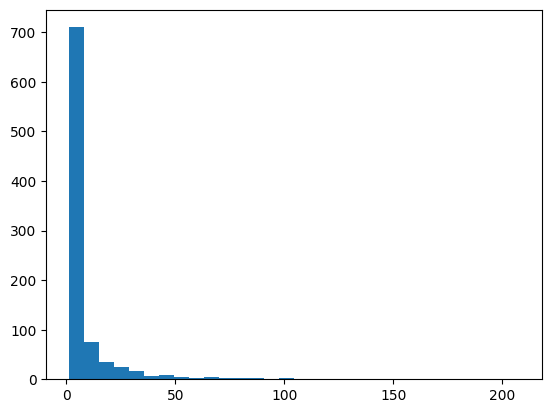

In [52]:
# specify the length of input tokens
plt.hist([len(x['en'].split()) for x in split['train']['translation']], bins=30);

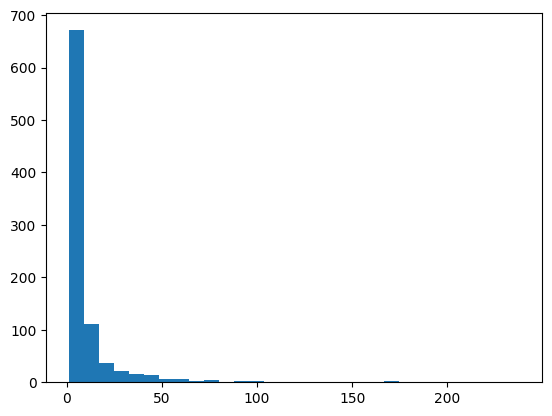

In [53]:
# specify the length of output tokens
plt.hist([len(x['fr'].split()) for x in split['train']['translation']], bins=30);

In [54]:
max_input_length = 40
max_target_length = 40

def tokenizer_fn(batch):
  inputs = [x['en'] for x in batch['translation']]
  targets = [x['fr'] for x in batch['translation']]

  tokenized_inputs = tokenizer(inputs, max_length= max_input_length, truncation = True)
  tokenized_targets = tokenizer(text_target = targets, max_length= max_target_length, truncation = True)

  tokenized_inputs['labels'] = tokenized_targets['input_ids']

  return tokenized_inputs

In [55]:
tokenized_datasets = split.map(tokenizer_fn, batched=True, remove_columns=split['train'].column_names)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [58]:
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [60]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)

In [61]:
#test data collator
[tokenized_datasets['train'][i] for i in range(1,3)]

[{'input_ids': [35,
   6443,
   301,
   1002,
   94,
   118,
   16718,
   18,
   4,
   1437,
   301,
   548,
   71,
   301,
   5024,
   301,
   602,
   0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [87,
   6,
   14916,
   301,
   1002,
   15,
   90,
   19954,
   51,
   31,
   19,
   2428,
   301,
   548,
   17,
   301,
   331,
   402,
   29033,
   583,
   402,
   29033,
   301,
   602,
   0]},
 {'input_ids': [34952, 8327, 0],
  'attention_mask': [1, 1, 1],
  'labels': [836, 9259, 8327, 0]}]

In [63]:
batch = data_collator([tokenized_datasets['train'][i] for i in range(1,3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [64]:
batch['labels']

tensor([[   87,     6, 14916,   301,  1002,    15,    90, 19954,    51,    31,
            19,  2428,   301,   548,    17,   301,   331,   402, 29033,   583,
           402, 29033,   301,   602,     0],
        [  836,  9259,  8327,     0,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100]])

In [65]:
batch['decoder_input_ids']

tensor([[59513,    87,     6, 14916,   301,  1002,    15,    90, 19954,    51,
            31,    19,  2428,   301,   548,    17,   301,   331,   402, 29033,
           583,   402, 29033,   301,   602],
        [59513,   836,  9259,  8327,     0, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513]])

In [69]:
tokenizer.convert_ids_to_tokens(batch['decoder_input_ids'][0])

['<pad>',
 '▁L',
 "'",
 'erreur',
 '▁%',
 '4',
 '▁a',
 '▁été',
 '▁détecté',
 'e',
 '▁dans',
 '▁le',
 '▁fichier',
 '▁%',
 '1',
 '▁à',
 '▁%',
 '2',
 '▁&',
 '▁#160;',
 '▁/',
 '▁&',
 '▁#160;',
 '▁%',
 '3']

In [70]:
tokenizer.convert_ids_to_tokens(batch['labels'][0])

['▁L',
 "'",
 'erreur',
 '▁%',
 '4',
 '▁a',
 '▁été',
 '▁détecté',
 'e',
 '▁dans',
 '▁le',
 '▁fichier',
 '▁%',
 '1',
 '▁à',
 '▁%',
 '2',
 '▁&',
 '▁#160;',
 '▁/',
 '▁&',
 '▁#160;',
 '▁%',
 '3',
 '</s>']

## evaluation

In [73]:
bleu_metric = load_metric('sacrebleu')
bert_metric = load_metric('bertscore')

<ipython-input-73-e458038bead4>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric('sacrebleu')


### compare bleu and bert (bert outperforms)

In [82]:
bleu_metric.compute(predictions=['I am unable to see the results of the work'],
                    references=[['I cannot see the outputs of the job']])

{'score': 12.549310621989482,
 'counts': [5, 2, 0, 0],
 'totals': [10, 9, 8, 7],
 'precisions': [50.0, 22.22222222222222, 6.25, 3.5714285714285716],
 'bp': 1.0,
 'sys_len': 10,
 'ref_len': 8}

In [84]:
bert_metric.compute(predictions=['I am unable to see the results of the work'],
                    references=[['I cannot see the outputs of the job']],
                    lang='en')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9446243047714233],
 'recall': [0.9483727216720581],
 'f1': [0.9464947581291199],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.34.0)'}